# Obesity Level Estimation using Machine Learning

## 1. Introduction
This study investigates the effectiveness of various machine learning algorithms for obesity level classification using lifestyle and anthropometric data.


#### OBJECTIVES:
1. Compare performance of Decision Tree, K-Nearest Neighbors, Support Vector 
    Machine, and Logistic Regression for obesity classification
2. Evaluate the impact of proper feature encoding on model performance
3. Identify the most suitable algorithm for obesity level prediction

#### DATASET: ObesityDataSet_raw_and_data_sinthetic.csv
- Contains 2111 samples with 17 features
- 7 obesity levels: Insufficient_Weight, Normal_Weight, Overweight_Level_I, Overweight_Level_II, Obesity_Type_I, Obesity_Type_II, Obesity_Type_III
- Features include demographic, anthropometric, and lifestyle factors

In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


## 2. Functions

Functions re-used are included in this section

#### Remove Outliers function

In [2]:
def remove_outliers(df, column):
    """
    Remove outliers using the Interquartile Range (IQR) method.

    JUSTIFICATION:
    - IQR method is robust and widely accepted in medical research
    - Uses 1.5 * IQR rule which captures approximately 99.3% of normal data
    - More robust than z-score method for non-normal distributions
    - Preserves data integrity while removing extreme values that could bias models

    METHODOLOGY:
    1. Calculate Q1 (25th percentile) and Q3 (75th percentile)
    2. Compute IQR = Q3 - Q1
    3. Define lower bound = Q1 - 1.5 * IQR
    4. Define upper bound = Q3 + 1.5 * IQR
    5. Remove values outside these bounds

    PARAMETERS:
    - df: DataFrame containing the data
    - column: Column name to process for outliers

    RETURNS:
    - DataFrame with outliers removed
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

#### Confusion Matrix Analysis function

In [3]:
def analyze_confusion_matrix(y_true, y_pred, model_name, model_type="Model", class_names=None):
    """
    Perform comprehensive confusion matrix analysis for model evaluation.
    
    METHODOLOGY:
    - Confusion matrix visualization for classification performance
    - Error pattern analysis for model interpretability
    - Per-class accuracy assessment for medical applications
    - Systematic error identification for model improvement
    
    PARAMETERS:
    - y_true: True labels
    - y_pred: Predicted labels
    - model_name: Name of the model (e.g., "Decision Tree")
    - model_type: Type of model (e.g., "Baseline", "Tuned")
    - class_names: Optional list of class names for labeling
    
    RETURNS:
    - dict: Dictionary containing confusion matrix and analysis results
    """
    print(f"\n{model_type.upper()} CONFUSION MATRIX ANALYSIS:")
    print("="*50)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualize confusion matrix
    # Use class names for axis labels if provided
    if class_names is not None:
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
                    xticklabels=class_names, yticklabels=class_names)
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    
    # plt.figure(figsize=(8, 8))
    plt.title(f"{model_name} - {model_type} Model Confusion Matrix")
    plt.xlabel("Predicted Obesity Level")
    plt.ylabel("Actual Obesity Level")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Quantitative analysis
    print(f"\n{model_type.upper()} ERROR ANALYSIS:")
    print("="*50)
    
    total_samples = cm.sum()
    correct_predictions = np.trace(cm)
    total_misclassifications = total_samples - correct_predictions
    overall_accuracy = correct_predictions / total_samples
    
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Total misclassifications: {total_misclassifications}")
    print(f"Overall accuracy: {overall_accuracy:.4f}")
    
    # Per-class analysis
    print(f"\nPER-CLASS ACCURACY ANALYSIS:")
    print("="*50)
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(cm))]
    
    class_analysis = {}
    for i, class_name in enumerate(class_names):
        class_total = cm[i, :].sum()
        class_correct = cm[i, i]
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        class_errors = class_total - class_correct
        
        print(f"{class_name}:")
        print(f"  Total samples: {class_total}")
        print(f"  Correct predictions: {class_correct}")
        print(f"  Misclassifications: {class_errors}")
        print(f"  Accuracy: {class_accuracy:.4f}")
        
        class_analysis[class_name] = {
            'total': class_total,
            'correct': class_correct,
            'errors': class_errors,
            'accuracy': class_accuracy
        }
    
    # Error pattern analysis
    print(f"\nERROR PATTERN ANALYSIS:")
    print("="*50)
    
    # Find most confused classes
    error_matrix = cm.copy()
    np.fill_diagonal(error_matrix, 0)  # Remove correct predictions
    
    if error_matrix.sum() > 0:
        max_error_idx = np.unravel_index(error_matrix.argmax(), error_matrix.shape)
        max_errors = error_matrix[max_error_idx]
        most_confused_classes = f"{class_names[max_error_idx[0]]} → {class_names[max_error_idx[1]]}"
        
        print(f"Most common error: {most_confused_classes} ({max_errors} cases)")
        
        # Find all significant errors (>5% of class)
        significant_errors = []
        for i in range(len(cm)):
            for j in range(len(cm)):
                if i != j and cm[i, j] > 0:
                    error_rate = cm[i, j] / cm[i, :].sum()
                    if error_rate > 0.05:  # 5% threshold
                        significant_errors.append({
                            'from': class_names[i],
                            'to': class_names[j],
                            'count': cm[i, j],
                            'rate': error_rate
                        })
        
        if significant_errors:
            print(f"Significant error patterns (>5% of class):")
            for error in sorted(significant_errors, key=lambda x: x['rate'], reverse=True):
                print(f"  {error['from']} → {error['to']}: {error['count']} cases ({error['rate']:.3f})")
    
    return {
        'confusion_matrix': cm,
        'overall_accuracy': overall_accuracy,
        'total_misclassifications': total_misclassifications,
        'class_analysis': class_analysis,
        'error_patterns': significant_errors if 'significant_errors' in locals() else []
    }

#### Hyperparameter Tuning Function

In [4]:
def perform_hyperparameter_tuning(model, param_grid, X_train, y_train, X_test, y_test, model_name, cv, baseline_accuracy, class_names=None):
    """
    Perform hyperparameter tuning using Grid Search with Cross-Validation.
    
    METHODOLOGY:
    - Systematic hyperparameter optimization using Grid Search
    - Cross-validation ensures robust performance estimation
    - Exhaustive search prevents missing optimal combinations
    - Essential for medical research where model reliability is critical
    
    PARAMETERS:
    - model: sklearn model instance (untrained)
    - param_grid: Dictionary of parameter grids to search
    - X_train: Training features
    - y_train: Training labels
    - X_test: Test features
    - y_test: Test labels
    - model_name: Name of the model for reporting
    - cv: Cross-validation instance (e.g., StratifiedKFold)
    - baseline_accuracy: Baseline model accuracy for comparison
    - class_names: Optional list of class names for labeling
    
    RETURNS:
    - dict: Dictionary containing best model, best parameters, and tuning results
    """
    print(f"\n" + "="*70)
    print(f"HYPERPARAMETER TUNING: {model_name}")
    print("="*70)
    
    print(f"\nTUNING METHODOLOGY:")
    print("- Technique: Grid Search with Cross-Validation")
    print(f"- Cross-validation: {type(cv).__name__}")
    print(f"- Parameter combinations: {sum(len(v) for v in param_grid.values())}")
    print(f"- Total evaluations: {sum(len(v) for v in param_grid.values()) * cv.n_splits}")
    
    # Initialize Grid Search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,  # Use all available cores
        verbose=1,
        return_train_score=True
    )
    
    print(f"\nPERFORMING GRID SEARCH:")
    print("="*50)
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Get best results
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"\nTUNING RESULTS:")
    print("="*50)
    print(f"Best cross-validation accuracy: {best_score:.4f}")
    print(f"Best parameters: {best_params}")
    print(f"Number of parameter combinations tested: {len(grid_search.cv_results_['params'])}")
    
    # Performance comparison
    print(f"\nPERFORMANCE COMPARISON:")
    print("="*50)
    
    # Evaluate best model on single split
    best_model.fit(X_train, y_train)
    best_predictions = best_model.predict(X_test)
    best_single_accuracy = accuracy_score(y_test, best_predictions)
    
    print(f"Best model single split accuracy: {best_single_accuracy:.4f}")
    print(f"Improvement over baseline: {best_single_accuracy - baseline_accuracy:.4f}")
    
    # Detailed classification report
    print(f"\nDETAILED CLASSIFICATION REPORT (Tuned Model):")
    print(classification_report(y_test, best_predictions))

    if class_names is None:
        class_names = best_model.classes_

    
    # Confusion Matrix Analysis using reusable function
    cm_analysis = analyze_confusion_matrix(y_test, best_predictions, model_name, "Tuned", class_names)
    
    # Parameter importance analysis
    print(f"\nPARAMETER IMPORTANCE ANALYSIS:")
    print("="*50)
    
    # Get all results
    cv_results = grid_search.cv_results_
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'params': cv_results['params'],
        'mean_test_score': cv_results['mean_test_score'],
        'std_test_score': cv_results['std_test_score'],
        'rank_test_score': cv_results['rank_test_score']
    })
    
    print("Top 5 parameter combinations:")
    top_5 = results_df.nsmallest(5, 'rank_test_score')
    for i, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"{i}. Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
        print(f"   Params: {row['params']}")
    
    # Get CV standard deviation for best model
    best_cv_std = cv_results['std_test_score'][cv_results['rank_test_score'].argmin()]
    
    return {
        'best_model': best_model,
        'best_params': best_params,
        'best_cv_score': best_score,
        'best_cv_std': best_cv_std,
        'best_single_accuracy': best_single_accuracy,
        'predictions': best_predictions,
        'cv_results': cv_results,
        'results_df': results_df
    }


## 3. Data Loading

In [5]:
print("Loading dataset...")
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
print(f"Dataset shape: {df.shape}")
print(df.head())

Loading dataset...
Dataset shape: (2111, 17)
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Nor

## 4. Data Exploration

METHODOLOGY: Exploratory Data Analysis (EDA)

PURPOSE:
- Understand data structure and quality
- Identify potential data quality issues
- Assess class balance for classification task
- Examine feature distributions and relationships
- Inform preprocessing decisions

EDA COMPONENTS:
1. Dataset Overview: Shape, data types, memory usage
2. Missing Value Analysis: Data completeness assessment
3. Target Variable Analysis: Class distribution and balance
4. Descriptive Statistics: Central tendency and variability measures


1. DATASET OVERVIEW:
Shape of dataset: (2111, 17)

Column types and non-null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC      

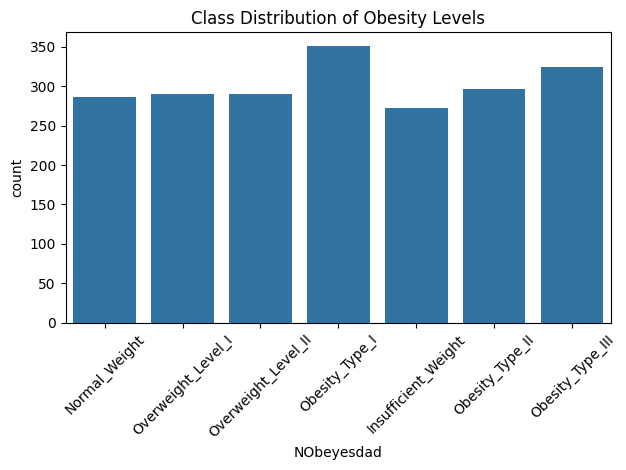


Class balance assessment:
Most frequent class: 351 samples
Least frequent class: 272 samples
Imbalance ratio: 1.29:1

4. DESCRIPTIVE STATISTICS:
Summary statistics for numerical features:
               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std

In [6]:
# 1. DATASET OVERVIEW
print("\n1. DATASET OVERVIEW:")
print("Shape of dataset:", df.shape)
print("\nColumn types and non-null values:")
print(df.info())

# 2. MISSING VALUE ANALYSIS
print("\n2. MISSING VALUE ANALYSIS:")
print("Missing values per column:")
missing_counts = df.isnull().sum()
print(missing_counts)
print(f"\nTotal missing values: {missing_counts.sum()}")
print(f"Data completeness: {((len(df) - missing_counts.sum()) / (len(df) * len(df.columns))) * 100:.2f}%")

# 3. TARGET VARIABLE ANALYSIS
print("\n3. TARGET VARIABLE ANALYSIS:")
print("Class distribution:")
class_dist = df["NObeyesdad"].value_counts()
print(class_dist)
sns.countplot(data=df, x="NObeyesdad")
plt.title("Class Distribution of Obesity Levels")
# plt.figure(figsize=(7, 5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"\nClass balance assessment:")
print(f"Most frequent class: {class_dist.max()} samples")
print(f"Least frequent class: {class_dist.min()} samples")
print(f"Imbalance ratio: {class_dist.max() / class_dist.min():.2f}:1")

# 4. DESCRIPTIVE STATISTICS
print("\n4. DESCRIPTIVE STATISTICS:")
print("Summary statistics for numerical features:")
print(df.describe())

## 5. Data Cleaning
PURPOSE:
- Ensure data quality and consistency
- Remove or handle data quality issues
- Prepare data for machine learning algorithms
- Maintain data integrity while improving model performance
 
CLEANING STEPS:
1. Data Quality Assessment: Missing values, inconsistencies
2. String Normalization: Remove whitespace and standardize text
3. Categorical Validation: Check for invalid or inconsistent categories
4. Outlier Detection and Removal: Use IQR method for numerical features
 
RESEARCH JUSTIFICATION:
- Data cleaning is crucial for reliable machine learning results
- Outlier removal prevents model bias from extreme values
- String normalization ensures consistent categorical encoding
- Quality assessment informs preprocessing decisions

In [7]:
# Copy the original dataset for cleaning
df_clean = df.copy()
print(f"Original dataset shape: {df_clean.shape}")

# 1. MISSING VALUE ASSESSMENT
print("\n1. MISSING VALUE ASSESSMENT:")
missing_counts = df_clean.isnull().sum()
print("Missing values per column:")
print(missing_counts)
print(f"Total missing values: {missing_counts.sum()}")

# 2. STRING NORMALIZATION
print("\n2. STRING NORMALIZATION:")
print("Removing leading/trailing whitespace from categorical variables...")
df_clean = df_clean.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
print("String normalization completed.")

# 3. CATEGORICAL VALIDATION
print("\n3. CATEGORICAL VALIDATION:")
print("Checking for invalid or inconsistent categories:")
for col in df_clean.select_dtypes(include='object').columns:
    print(f"\nUnique values in {col}:")
    unique_vals = df_clean[col].unique()
    print(unique_vals)
    print(f"Number of unique values: {len(unique_vals)}")

# 4. OUTLIER DETECTION AND REMOVAL
print("\n4. OUTLIER DETECTION AND REMOVAL:")
print("Applying IQR method to remove outliers from Height and Weight...")
print(f"Dataset shape before outlier removal: {df_clean.shape}")

# Remove outliers from Height and Weight (most critical anthropometric measures)
df_clean = remove_outliers(df_clean, "Height")
df_clean = remove_outliers(df_clean, "Weight")

print(f"Dataset shape after outlier removal: {df_clean.shape}")
print(f"Removed {df.shape[0] - df_clean.shape[0]} samples due to outliers")
print(f"Data retention rate: {(df_clean.shape[0] / df.shape[0]) * 100:.2f}%")

Original dataset shape: (2111, 17)

1. MISSING VALUE ASSESSMENT:
Missing values per column:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
Total missing values: 0

2. STRING NORMALIZATION:
Removing leading/trailing whitespace from categorical variables...
String normalization completed.

3. CATEGORICAL VALIDATION:
Checking for invalid or inconsistent categories:

Unique values in Gender:
['Female' 'Male']
Number of uni

## 6. Preprocessing
RESEARCH METHODOLOGY: Feature Engineering and Encoding

PURPOSE:
- Transform raw data into machine learning-ready format
- Apply appropriate encoding for different feature types
- Ensure compatibility with machine learning algorithms
- Maintain interpretability while improving model performance
 
PREPROCESSING STRATEGY:
1. Feature Type Classification: Categorize features by data type and characteristics
2. Encoding Strategy Selection: Choose appropriate encoding for each feature type
3. Scaling Application: Standardize numerical features for distance-based algorithms
4. Pipeline Construction: Create reproducible preprocessing workflow
 
RESEARCH JUSTIFICATION:
- Proper encoding is crucial for algorithm performance
- Different algorithms require different preprocessing approaches
- Feature engineering impacts model interpretability
- Pipeline ensures reproducibility and prevents data leakage

In [8]:
# Separate features and target
X = df_clean.drop('NObeyesdad', axis=1)
y_raw = df_clean['NObeyesdad']

# Encode the target variable
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y_raw)

print("Target variable encoding:")
for i, label in enumerate(target_encoder.classes_):
    print(f"  {i}: {label}")

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# FEATURE TYPE CLASSIFICATION
print("\n1. FEATURE TYPE CLASSIFICATION:")
print("Categorizing features based on data type and characteristics...")

# Numerical features (continuous and discrete)
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

# Categorical features without natural order (nominal)
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']
print(f"\nCategorical features - Nominal ({len(categorical_features)}): {categorical_features}")

# Categorical features with natural order (ordinal)
ordinal_features = ['CAEC', 'CALC']
print(f"\nCategorical features - Ordinal ({len(ordinal_features)}): {ordinal_features}")

print(f"\nTotal features: {len(numerical_features) + len(categorical_features) + len(ordinal_features)}")

Target variable encoding:
  0: Insufficient_Weight
  1: Normal_Weight
  2: Obesity_Type_I
  3: Obesity_Type_II
  4: Obesity_Type_III
  5: Overweight_Level_I
  6: Overweight_Level_II
Feature matrix shape: (2109, 16)
Target vector shape: (2109,)

1. FEATURE TYPE CLASSIFICATION:
Categorizing features based on data type and characteristics...
Numerical features (8): ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

Categorical features - Nominal (6): ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']

Categorical features - Ordinal (2): ['CAEC', 'CALC']

Total features: 16


In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
        ('ord', OrdinalEncoder(), ordinal_features)
    ],
    remainder='drop'
)

# Split the data before encoding to avoid data leakage: the model should not see the test set during training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### 6.1 Feature Analysis and Clinical Relevance
PURPOSE:
- Analyze the clinical relevance of lifestyle and anthropometric features
- Understand feature distributions and their relationship to obesity
- Identify key factors influencing obesity classification
- Provide clinical interpretation of feature importance
 
CLINICAL ANALYSIS COMPONENTS:
1. Anthropometric Feature Analysis: Height, Weight, BMI relationships
2. Lifestyle Feature Analysis: Physical activity, eating habits, screen time
3. Demographic Feature Analysis: Age, gender, family history
4. Feature-Target Relationship Analysis: Correlation with obesity levels


1. ANTHROPOMETRIC FEATURE ANALYSIS:
BMI Distribution by Obesity Level:
                          mean       std        min        max
NObeyesdad                                                    
Insufficient_Weight  174042.45   7862.31  129986.85  190822.06
Normal_Weight        220141.47  18420.17  184911.24  249134.95
Obesity_Type_I       322566.97  11324.02  299119.58  351710.95
Obesity_Type_II      367234.24  12901.27  340485.09  397866.52
Obesity_Type_III     422514.59  25512.46  367744.00  508117.53
Overweight_Level_I   259907.72   6608.22  228267.39  287696.07
Overweight_Level_II  282152.32   8278.62  257135.13  303628.77


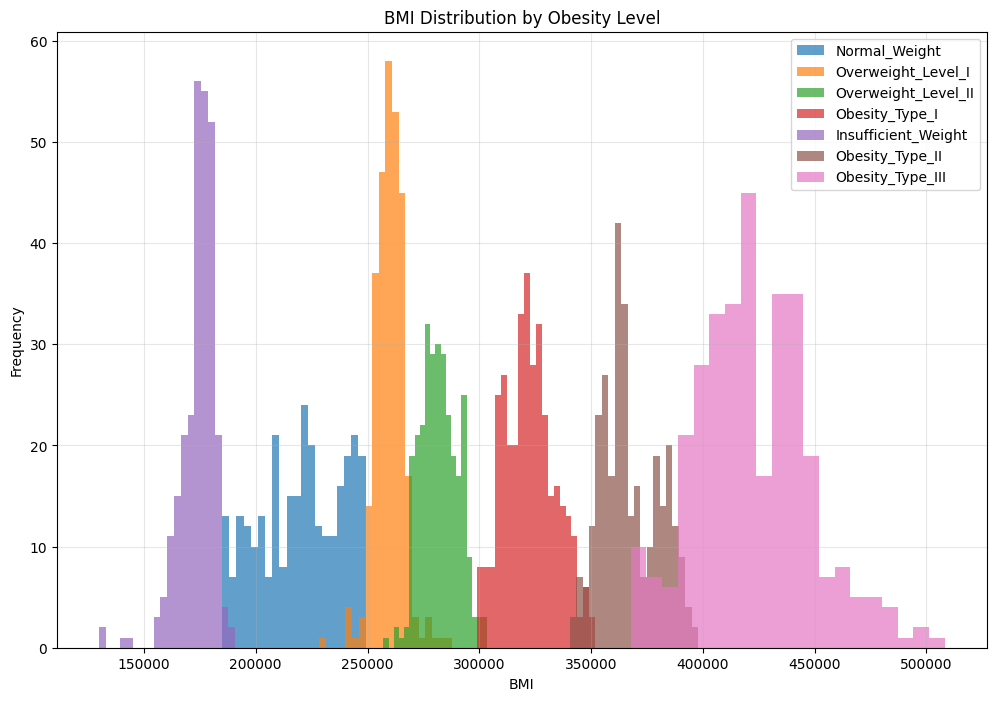

In [10]:
# 1. ANTHROPOMETRIC FEATURE ANALYSIS
print("\n1. ANTHROPOMETRIC FEATURE ANALYSIS:")
print("="*50)

# Calculate BMI for analysis
df_analysis = df_clean.copy()
df_analysis['BMI'] = df_analysis['Weight'] / ((df_analysis['Height'] / 100) ** 2)

print("BMI Distribution by Obesity Level:")
bmi_by_obesity = df_analysis.groupby('NObeyesdad')['BMI'].agg(['mean', 'std', 'min', 'max'])
print(bmi_by_obesity.round(2))

# Visualize BMI distribution
plt.figure(figsize=(12, 8))
for obesity_level in df_analysis['NObeyesdad'].unique():
    subset = df_analysis[df_analysis['NObeyesdad'] == obesity_level]
    plt.hist(subset['BMI'], alpha=0.7, label=obesity_level, bins=20)

plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('BMI Distribution by Obesity Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# 2. LIFESTYLE FEATURE ANALYSIS
print("\n2. LIFESTYLE FEATURE ANALYSIS:")
print("="*50)

# Physical activity analysis
print("Physical Activity (FAF) by Obesity Level:")
faf_by_obesity = df_analysis.groupby('NObeyesdad')['FAF'].agg(['mean', 'std'])
print(faf_by_obesity.round(2))

# Screen time analysis
print("\nScreen Time (TUE) by Obesity Level:")
tue_by_obesity = df_analysis.groupby('NObeyesdad')['TUE'].agg(['mean', 'std'])
print(tue_by_obesity.round(2))


2. LIFESTYLE FEATURE ANALYSIS:
Physical Activity (FAF) by Obesity Level:
                     mean   std
NObeyesdad                     
Insufficient_Weight  1.25  0.86
Normal_Weight        1.25  1.02
Obesity_Type_I       0.99  0.90
Obesity_Type_II      0.97  0.58
Obesity_Type_III     0.66  0.73
Overweight_Level_I   1.06  0.85
Overweight_Level_II  0.96  0.82

Screen Time (TUE) by Obesity Level:
                     mean   std
NObeyesdad                     
Insufficient_Weight  0.84  0.64
Normal_Weight        0.68  0.69
Obesity_Type_I       0.68  0.69
Obesity_Type_II      0.52  0.56
Obesity_Type_III     0.60  0.28
Overweight_Level_I   0.61  0.68
Overweight_Level_II  0.70  0.59


In [12]:
# 3. EATING HABITS ANALYSIS
print("\n3. EATING HABITS ANALYSIS:")
print("="*50)

# Vegetable consumption
print("Vegetable Consumption (FCVC) by Obesity Level:")
fcvc_by_obesity = df_analysis.groupby('NObeyesdad')['FCVC'].agg(['mean', 'std'])
print(fcvc_by_obesity.round(2))

# Main meals per day
print("\nMain Meals per Day (NCP) by Obesity Level:")
ncp_by_obesity = df_analysis.groupby('NObeyesdad')['NCP'].agg(['mean', 'std'])
print(ncp_by_obesity.round(2))



3. EATING HABITS ANALYSIS:
Vegetable Consumption (FCVC) by Obesity Level:
                     mean   std
NObeyesdad                     
Insufficient_Weight  2.48  0.58
Normal_Weight        2.33  0.59
Obesity_Type_I       2.19  0.43
Obesity_Type_II      2.39  0.49
Obesity_Type_III     3.00  0.00
Overweight_Level_I   2.26  0.48
Overweight_Level_II  2.26  0.45

Main Meals per Day (NCP) by Obesity Level:
                     mean   std
NObeyesdad                     
Insufficient_Weight  2.91  0.90
Normal_Weight        2.74  0.87
Obesity_Type_I       2.43  0.79
Obesity_Type_II      2.74  0.58
Obesity_Type_III     3.00  0.00
Overweight_Level_I   2.50  0.96
Overweight_Level_II  2.50  0.75



4. FEATURE-TARGET CORRELATION ANALYSIS:
Correlation with Obesity Level (Numerical Features):
  Weight: 0.388
  Age: 0.236
  FAF: -0.130
  CH2O: 0.109
  NCP: -0.093
  TUE: -0.069
  Height: 0.039
  FCVC: 0.018


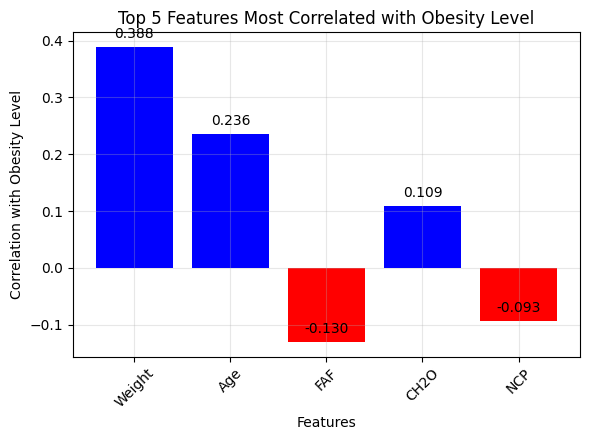

In [13]:
# 4. FEATURE-TARGET CORRELATION ANALYSIS
print("\n4. FEATURE-TARGET CORRELATION ANALYSIS:")
print("="*50)

# Calculate correlation with obesity levels (encoded)
y_encoded = target_encoder.transform(df_analysis['NObeyesdad'])

# Numerical feature correlations
numerical_correlations = {}
for feature in numerical_features:
    correlation = np.corrcoef(df_analysis[feature], y_encoded)[0, 1]
    numerical_correlations[feature] = correlation

print("Correlation with Obesity Level (Numerical Features):")
for feature, corr in sorted(numerical_correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"  {feature}: {corr:.3f}")

# Visualize top correlations
top_features = sorted(numerical_correlations.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
feature_names_corr = [f[0] for f in top_features]
correlation_values = [f[1] for f in top_features]

plt.figure(figsize=(6, 4.5))
bars = plt.bar(range(len(feature_names_corr)), correlation_values, 
               color=['red' if x < 0 else 'blue' for x in correlation_values])
plt.xlabel('Features')
plt.ylabel('Correlation with Obesity Level')
plt.title('Top 5 Features Most Correlated with Obesity Level')
plt.xticks(range(len(feature_names_corr)), feature_names_corr, rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, correlation_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [14]:
# Fit and transform the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Shape of training set: {X_train_processed.shape}")
print(f"Shape of test set: {X_test_processed.shape}")

# Get feature names for interpretation
feature_names = numerical_features + ordinal_features
# Add categorical feature names (simplified)
for col in categorical_features:
    feature_names.append(f"{col}_encoded")
print(f"Total features after preprocessing: {len(feature_names)}")

Shape of training set: (1687, 19)
Shape of test set: (422, 19)
Total features after preprocessing: 16


## 7. Models

#### 7.1 Decision Tree Classifier
ALGORITHM SELECTION JUSTIFICATION:
- Decision Trees are interpretable and can handle both numerical and categorical features
- Non-parametric approach that doesn't assume data distribution
- Can capture non-linear relationships in the data
- Provides feature importance rankings for medical interpretation
- Suitable for multi-class classification problems
 
THEORETICAL BACKGROUND:
- Decision Trees use recursive binary splitting to partition feature space
- Each split maximizes information gain or minimizes impurity
- Tree depth controls model complexity and prevents overfitting
- Leaf nodes contain class predictions based on majority voting
 
PARAMETER SELECTION:
- random_state=42: Ensures reproducibility of results
- Default parameters: Allow algorithm to find optimal splits without bias
- No hyperparameter tuning: Focus on baseline performance comparison
 
EXPECTED ADVANTAGES:
- High interpretability for medical applications
- Can handle mixed data types naturally
- Robust to outliers and missing values
- Provides feature importance for clinical insights

##### 7.1.1. Baseline Decision Tree Evaluation


DECISION TREE BASELINE MODEL EVALUATION:
Baseline Decision Tree Accuracy: 0.9242

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91        54
           1       0.78      0.82      0.80        57
           2       0.95      0.99      0.97        70
           3       0.98      0.95      0.97        60
           4       1.00      1.00      1.00        65
           5       0.82      0.88      0.85        58
           6       0.96      0.95      0.96        58

    accuracy                           0.92       422
   macro avg       0.93      0.92      0.92       422
weighted avg       0.93      0.92      0.92       422


BASELINE CONFUSION MATRIX ANALYSIS:


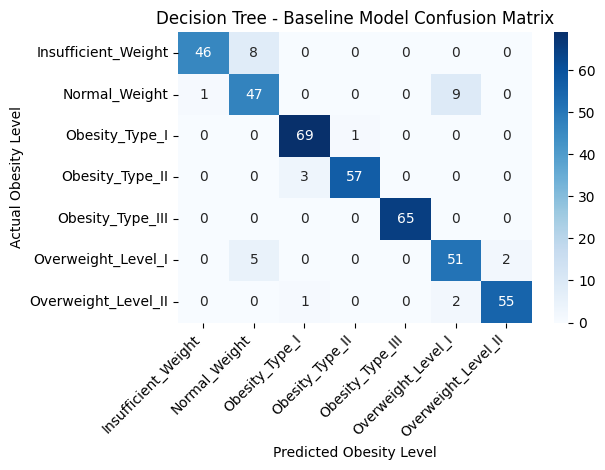


BASELINE ERROR ANALYSIS:
Total samples: 422
Correct predictions: 390
Total misclassifications: 32
Overall accuracy: 0.9242

PER-CLASS ACCURACY ANALYSIS:
Insufficient_Weight:
  Total samples: 54
  Correct predictions: 46
  Misclassifications: 8
  Accuracy: 0.8519
Normal_Weight:
  Total samples: 57
  Correct predictions: 47
  Misclassifications: 10
  Accuracy: 0.8246
Obesity_Type_I:
  Total samples: 70
  Correct predictions: 69
  Misclassifications: 1
  Accuracy: 0.9857
Obesity_Type_II:
  Total samples: 60
  Correct predictions: 57
  Misclassifications: 3
  Accuracy: 0.9500
Obesity_Type_III:
  Total samples: 65
  Correct predictions: 65
  Misclassifications: 0
  Accuracy: 1.0000
Overweight_Level_I:
  Total samples: 58
  Correct predictions: 51
  Misclassifications: 7
  Accuracy: 0.8793
Overweight_Level_II:
  Total samples: 58
  Correct predictions: 55
  Misclassifications: 3
  Accuracy: 0.9483

ERROR PATTERN ANALYSIS:
Most common error: Normal_Weight → Overweight_Level_I (9 cases)
Signi

In [15]:
print("\nDECISION TREE BASELINE MODEL EVALUATION:")
print("="*50)

# Initialize and train baseline Decision Tree
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_processed, y_train)

# Evaluate baseline model
dt_baseline_pred = dt_baseline.predict(X_test_processed)
dt_baseline_accuracy = accuracy_score(y_test, dt_baseline_pred)

print(f"Baseline Decision Tree Accuracy: {dt_baseline_accuracy:.4f}")
print("\nBaseline Classification Report:")
print(classification_report(y_test, dt_baseline_pred))

# Baseline Confusion Matrix Analysis using reusable function
dt_baseline_analysis = analyze_confusion_matrix(y_test, dt_baseline_pred, "Decision Tree", "Baseline", target_encoder.classes_)

##### 7.1.2 Hyperparameter tuning for Decision Tree


HYPERPARAMETER TUNING: DECISION TREE

PARAMETER GRID:
- max_depth: [3, 5, 7, 10, None]
- min_samples_split: [2, 5, 10]
- min_samples_leaf: [1, 2, 4]
- criterion: ['gini', 'entropy']
- Total combinations: 90

HYPERPARAMETER TUNING: Decision Tree

TUNING METHODOLOGY:
- Technique: Grid Search with Cross-Validation
- Cross-validation: StratifiedKFold
- Parameter combinations: 13
- Total evaluations: 65

PERFORMING GRID SEARCH:
Fitting 5 folds for each of 90 candidates, totalling 450 fits

TUNING RESULTS:
Best cross-validation accuracy: 0.9472
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Number of parameter combinations tested: 90

PERFORMANCE COMPARISON:
Best model single split accuracy: 0.9716
Improvement over baseline: 0.0474

DETAILED CLASSIFICATION REPORT (Tuned Model):
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        54
           1       0.92      0.96      0.94   

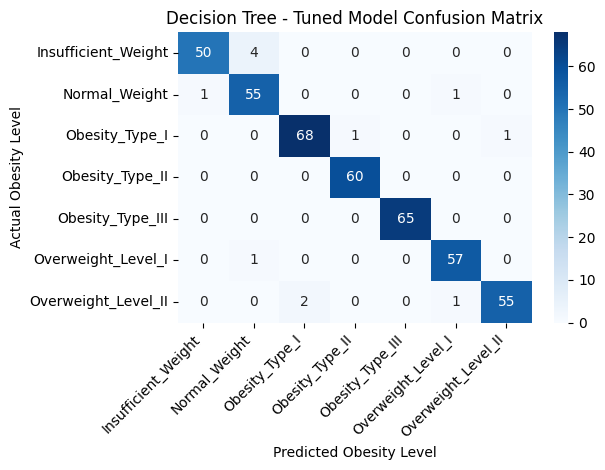


TUNED ERROR ANALYSIS:
Total samples: 422
Correct predictions: 410
Total misclassifications: 12
Overall accuracy: 0.9716

PER-CLASS ACCURACY ANALYSIS:
Insufficient_Weight:
  Total samples: 54
  Correct predictions: 50
  Misclassifications: 4
  Accuracy: 0.9259
Normal_Weight:
  Total samples: 57
  Correct predictions: 55
  Misclassifications: 2
  Accuracy: 0.9649
Obesity_Type_I:
  Total samples: 70
  Correct predictions: 68
  Misclassifications: 2
  Accuracy: 0.9714
Obesity_Type_II:
  Total samples: 60
  Correct predictions: 60
  Misclassifications: 0
  Accuracy: 1.0000
Obesity_Type_III:
  Total samples: 65
  Correct predictions: 65
  Misclassifications: 0
  Accuracy: 1.0000
Overweight_Level_I:
  Total samples: 58
  Correct predictions: 57
  Misclassifications: 1
  Accuracy: 0.9828
Overweight_Level_II:
  Total samples: 58
  Correct predictions: 55
  Misclassifications: 3
  Accuracy: 0.9483

ERROR PATTERN ANALYSIS:
Most common error: Insufficient_Weight → Normal_Weight (4 cases)
Signific

In [16]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING: DECISION TREE")
print("="*60)

# Define parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

print("\nPARAMETER GRID:")
print(f"- max_depth: {dt_param_grid['max_depth']}")
print(f"- min_samples_split: {dt_param_grid['min_samples_split']}")
print(f"- min_samples_leaf: {dt_param_grid['min_samples_leaf']}")
print(f"- criterion: {dt_param_grid['criterion']}")
print(f"- Total combinations: {len(dt_param_grid['max_depth']) * len(dt_param_grid['min_samples_split']) * len(dt_param_grid['min_samples_leaf']) * len(dt_param_grid['criterion'])}")

# Perform hyperparameter tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt_tuning_results = perform_hyperparameter_tuning(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    X_train_processed,
    y_train,
    X_test_processed,
    y_test,
    "Decision Tree",
    cv,
    dt_baseline_accuracy,
    target_encoder.classes_
)

# Extract tuned results
dt_tuned_model = dt_tuning_results['best_model']
dt_best_params = dt_tuning_results['best_params']
dt_tuned_accuracy = dt_tuning_results['best_single_accuracy']
dt_tuned_cv_score = dt_tuning_results['best_cv_score']

##### 7.1.3. Baseline vs Tuned Comparison for Decision Tree


BASELINE vs TUNED COMPARISON FOR DECISION TREE
Baseline Accuracy: 0.9242
Tuned Accuracy: 0.9716
Improvement: 0.0474
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

MODEL INTERPRETABILITY:
Tree depth: 11
Number of leaves: 81
Number of features used: 19

FEATURE IMPORTANCE ANALYSIS:
Top 10 most important features:
                      Feature  Importance
2            Feature_Weight_2    0.604902
1            Feature_Height_1    0.211801
8              Feature_CAEC_8    0.122115
0               Feature_Age_0    0.018028
10  Feature_Gender_encoded_10    0.011610
5              Feature_CH2O_5    0.011146
4               Feature_NCP_4    0.008830
3              Feature_FCVC_3    0.004987
17           Feature_Extra_17    0.004547
6               Feature_FAF_6    0.001609


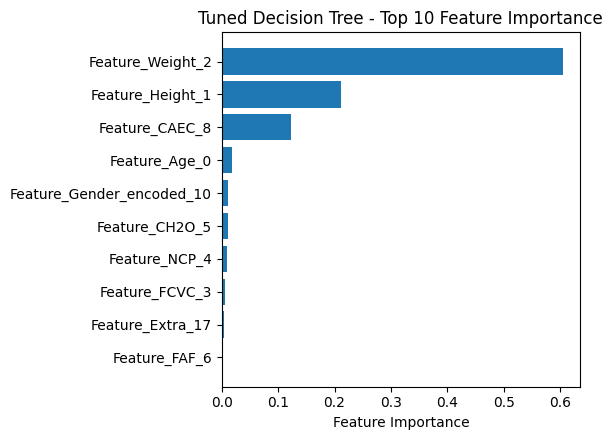

In [17]:
print("\n" + "="*60)
print("BASELINE vs TUNED COMPARISON FOR DECISION TREE")
print("="*60)

print(f"Baseline Accuracy: {dt_baseline_accuracy:.4f}")
print(f"Tuned Accuracy: {dt_tuned_accuracy:.4f}")
print(f"Improvement: {dt_tuned_accuracy - dt_baseline_accuracy:.4f}")
print(f"Best Parameters: {dt_best_params}")

# Model interpretability analysis
print("\nMODEL INTERPRETABILITY:")
print(f"Tree depth: {dt_tuned_model.get_depth()}")
print(f"Number of leaves: {dt_tuned_model.get_n_leaves()}")
print(f"Number of features used: {len(dt_tuned_model.feature_importances_)}")

# Feature importance analysis
print("\nFEATURE IMPORTANCE ANALYSIS:")
# Get the actual number of features from the model
actual_features = len(dt_tuned_model.feature_importances_)
if len(feature_names) != actual_features:
    print(f"WARNING: Feature count mismatch! Creating descriptive feature names.")
    # Create descriptive feature names using available feature names
    feature_names_actual = []
    for i in range(actual_features):
        if i < len(feature_names):
            # Use the actual feature name if available
            feature_names_actual.append(f"Feature_{feature_names[i]}_{i}")
        else:
            # Fallback to generic name for extra features
            feature_names_actual.append(f"Feature_Extra_{i}")
else:
    feature_names_actual = feature_names
feature_importance = pd.DataFrame({
    'Feature': feature_names_actual,
    'Importance': dt_tuned_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 most important features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(6, 4.5))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Tuned Decision Tree - Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Store results for final comparison
dt_accuracy = dt_tuned_accuracy  # Use tuned accuracy for final comparison
dt_model = dt_tuned_model
dt_pred = dt_tuning_results['predictions']

#### 7.2 K-Nearest Neighbors Classifier

##### 7.2.1 Baseline K-Nearest Neighbors Evaluation


K-NEAREST NEIGHBORS BASELINE MODEL EVALUATION:
Baseline K-Nearest Neighbors Accuracy: 0.8436

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        54
           1       0.73      0.47      0.57        57
           2       0.85      0.96      0.90        70
           3       0.92      0.98      0.95        60
           4       0.98      1.00      0.99        65
           5       0.79      0.71      0.75        58
           6       0.78      0.81      0.80        58

    accuracy                           0.84       422
   macro avg       0.83      0.84      0.83       422
weighted avg       0.84      0.84      0.84       422


BASELINE CONFUSION MATRIX ANALYSIS:


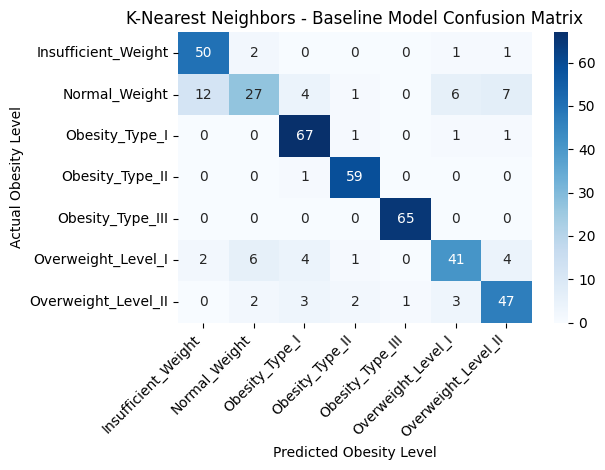


BASELINE ERROR ANALYSIS:
Total samples: 422
Correct predictions: 356
Total misclassifications: 66
Overall accuracy: 0.8436

PER-CLASS ACCURACY ANALYSIS:
Insufficient_Weight:
  Total samples: 54
  Correct predictions: 50
  Misclassifications: 4
  Accuracy: 0.9259
Normal_Weight:
  Total samples: 57
  Correct predictions: 27
  Misclassifications: 30
  Accuracy: 0.4737
Obesity_Type_I:
  Total samples: 70
  Correct predictions: 67
  Misclassifications: 3
  Accuracy: 0.9571
Obesity_Type_II:
  Total samples: 60
  Correct predictions: 59
  Misclassifications: 1
  Accuracy: 0.9833
Obesity_Type_III:
  Total samples: 65
  Correct predictions: 65
  Misclassifications: 0
  Accuracy: 1.0000
Overweight_Level_I:
  Total samples: 58
  Correct predictions: 41
  Misclassifications: 17
  Accuracy: 0.7069
Overweight_Level_II:
  Total samples: 58
  Correct predictions: 47
  Misclassifications: 11
  Accuracy: 0.8103

ERROR PATTERN ANALYSIS:
Most common error: Normal_Weight → Insufficient_Weight (12 cases)
S

In [18]:
print("\nK-NEAREST NEIGHBORS BASELINE MODEL EVALUATION:")
print("="*50)

# Initialize and train baseline KNN
knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train_processed, y_train)

# Evaluate baseline model
knn_baseline_pred = knn_baseline.predict(X_test_processed)
knn_baseline_accuracy = accuracy_score(y_test, knn_baseline_pred)

print(f"Baseline K-Nearest Neighbors Accuracy: {knn_baseline_accuracy:.4f}")
print("\nBaseline Classification Report:")
print(classification_report(y_test, knn_baseline_pred))

# Baseline Confusion Matrix Analysis using reusable function
knn_baseline_analysis = analyze_confusion_matrix(y_test, knn_baseline_pred, "K-Nearest Neighbors", "Baseline", target_encoder.classes_)


##### 7.2.2. Hyperparameter tuning for K-Nearest Neighbors


HYPERPARAMETER TUNING: K-NEAREST NEIGHBORS

PARAMETER GRID:
- n_neighbors: [3, 5, 7, 9, 11, 13]
- weights: ['uniform', 'distance']
- metric: ['euclidean', 'manhattan']
- Total combinations: 24

HYPERPARAMETER TUNING: K-Nearest Neighbors

TUNING METHODOLOGY:
- Technique: Grid Search with Cross-Validation
- Cross-validation: StratifiedKFold
- Parameter combinations: 10
- Total evaluations: 50

PERFORMING GRID SEARCH:
Fitting 5 folds for each of 24 candidates, totalling 120 fits

TUNING RESULTS:
Best cross-validation accuracy: 0.8791
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Number of parameter combinations tested: 24

PERFORMANCE COMPARISON:
Best model single split accuracy: 0.8910
Improvement over baseline: 0.0474

DETAILED CLASSIFICATION REPORT (Tuned Model):
              precision    recall  f1-score   support

           0       0.87      0.96      0.91        54
           1       0.76      0.61      0.68        57
           2       0.89   

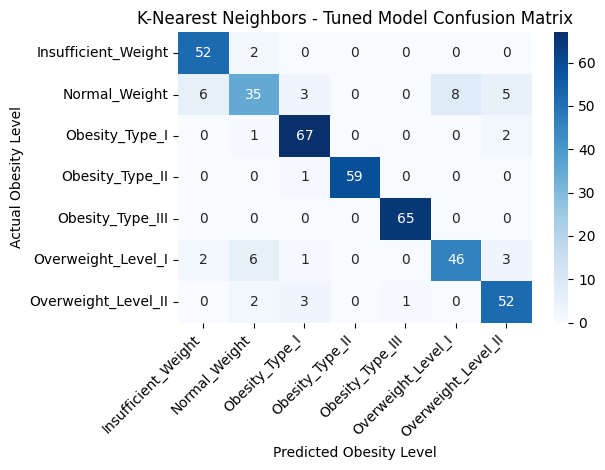


TUNED ERROR ANALYSIS:
Total samples: 422
Correct predictions: 376
Total misclassifications: 46
Overall accuracy: 0.8910

PER-CLASS ACCURACY ANALYSIS:
Insufficient_Weight:
  Total samples: 54
  Correct predictions: 52
  Misclassifications: 2
  Accuracy: 0.9630
Normal_Weight:
  Total samples: 57
  Correct predictions: 35
  Misclassifications: 22
  Accuracy: 0.6140
Obesity_Type_I:
  Total samples: 70
  Correct predictions: 67
  Misclassifications: 3
  Accuracy: 0.9571
Obesity_Type_II:
  Total samples: 60
  Correct predictions: 59
  Misclassifications: 1
  Accuracy: 0.9833
Obesity_Type_III:
  Total samples: 65
  Correct predictions: 65
  Misclassifications: 0
  Accuracy: 1.0000
Overweight_Level_I:
  Total samples: 58
  Correct predictions: 46
  Misclassifications: 12
  Accuracy: 0.7931
Overweight_Level_II:
  Total samples: 58
  Correct predictions: 52
  Misclassifications: 6
  Accuracy: 0.8966

ERROR PATTERN ANALYSIS:
Most common error: Normal_Weight → Overweight_Level_I (8 cases)
Signifi

In [19]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING: K-NEAREST NEIGHBORS")
print("="*60)

# Define parameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

print("\nPARAMETER GRID:")
print(f"- n_neighbors: {knn_param_grid['n_neighbors']}")
print(f"- weights: {knn_param_grid['weights']}")
print(f"- metric: {knn_param_grid['metric']}")
print(f"- Total combinations: {len(knn_param_grid['n_neighbors']) * len(knn_param_grid['weights']) * len(knn_param_grid['metric'])}")

# Perform hyperparameter tuning
knn_tuning_results = perform_hyperparameter_tuning(
    KNeighborsClassifier(),
    knn_param_grid,
    X_train_processed,
    y_train,
    X_test_processed,
    y_test,
    "K-Nearest Neighbors",
    cv,
    knn_baseline_accuracy,
    target_encoder.classes_
)

# Extract tuned results
knn_tuned_model = knn_tuning_results['best_model']
knn_best_params = knn_tuning_results['best_params']
knn_tuned_accuracy = knn_tuning_results['best_single_accuracy']
knn_tuned_cv_score = knn_tuning_results['best_cv_score']

##### 7.2.3. Baseline vs Tuned Comparison for K-Nearest Neighbors

In [20]:
print("\n" + "="*60)
print("BASELINE vs TUNED COMPARISON FOR K-NEAREST NEIGHBORS")
print("="*60)

print(f"Baseline Accuracy: {knn_baseline_accuracy:.4f}")
print(f"Tuned Accuracy: {knn_tuned_accuracy:.4f}")
print(f"Improvement: {knn_tuned_accuracy - knn_baseline_accuracy:.4f}")
print(f"Best Parameters: {knn_best_params}")

# Store results for final comparison
knn_accuracy = knn_tuned_accuracy  # Use tuned accuracy for final comparison
knn_model = knn_tuned_model
knn_pred = knn_tuning_results['predictions']


BASELINE vs TUNED COMPARISON FOR K-NEAREST NEIGHBORS
Baseline Accuracy: 0.8436
Tuned Accuracy: 0.8910
Improvement: 0.0474
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


#### 7.3. Support Vector Machine (SVM) Classifier

##### 7.3.1 Baseline SVM Evaluation


SUPPORT VECTOR MACHINE BASELINE MODEL EVALUATION:
Baseline Support Vector Machine Accuracy: 0.9265

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        54
           1       0.81      0.82      0.82        57
           2       0.93      0.99      0.96        70
           3       0.98      0.98      0.98        60
           4       1.00      1.00      1.00        65
           5       0.82      0.84      0.83        58
           6       0.98      0.84      0.91        58

    accuracy                           0.93       422
   macro avg       0.93      0.92      0.92       422
weighted avg       0.93      0.93      0.93       422


BASELINE CONFUSION MATRIX ANALYSIS:


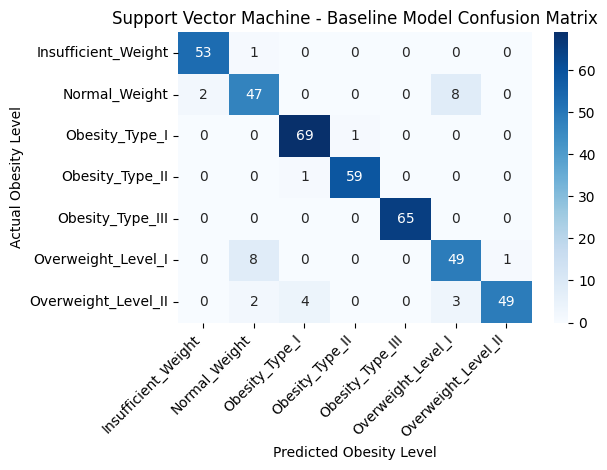


BASELINE ERROR ANALYSIS:
Total samples: 422
Correct predictions: 391
Total misclassifications: 31
Overall accuracy: 0.9265

PER-CLASS ACCURACY ANALYSIS:
Insufficient_Weight:
  Total samples: 54
  Correct predictions: 53
  Misclassifications: 1
  Accuracy: 0.9815
Normal_Weight:
  Total samples: 57
  Correct predictions: 47
  Misclassifications: 10
  Accuracy: 0.8246
Obesity_Type_I:
  Total samples: 70
  Correct predictions: 69
  Misclassifications: 1
  Accuracy: 0.9857
Obesity_Type_II:
  Total samples: 60
  Correct predictions: 59
  Misclassifications: 1
  Accuracy: 0.9833
Obesity_Type_III:
  Total samples: 65
  Correct predictions: 65
  Misclassifications: 0
  Accuracy: 1.0000
Overweight_Level_I:
  Total samples: 58
  Correct predictions: 49
  Misclassifications: 9
  Accuracy: 0.8448
Overweight_Level_II:
  Total samples: 58
  Correct predictions: 49
  Misclassifications: 9
  Accuracy: 0.8448

ERROR PATTERN ANALYSIS:
Most common error: Normal_Weight → Overweight_Level_I (8 cases)
Signi

In [21]:
print("\nSUPPORT VECTOR MACHINE BASELINE MODEL EVALUATION:")
print("="*50)

# Initialize and train baseline SVM
svm_baseline = SVC(kernel='rbf', random_state=42)
svm_baseline.fit(X_train_processed, y_train)

# Evaluate baseline model
svm_baseline_pred = svm_baseline.predict(X_test_processed)
svm_baseline_accuracy = accuracy_score(y_test, svm_baseline_pred)

print(f"Baseline Support Vector Machine Accuracy: {svm_baseline_accuracy:.4f}")
print("\nBaseline Classification Report:")
print(classification_report(y_test, svm_baseline_pred))

# Baseline Confusion Matrix Analysis using reusable function
svm_baseline_analysis = analyze_confusion_matrix(y_test, svm_baseline_pred, "Support Vector Machine", "Baseline", target_encoder.classes_)


##### 7.3.2 Hyperparameter tuning for Support Vector Machine


HYPERPARAMETER TUNING: SUPPORT VECTOR MACHINE

PARAMETER GRID:
- C: [0.1, 1, 10, 100]
- kernel: ['rbf', 'linear']
- gamma: ['scale', 'auto', 0.001, 0.01, 0.1]
- Total combinations: 40

HYPERPARAMETER TUNING: Support Vector Machine

TUNING METHODOLOGY:
- Technique: Grid Search with Cross-Validation
- Cross-validation: StratifiedKFold
- Parameter combinations: 11
- Total evaluations: 55

PERFORMING GRID SEARCH:
Fitting 5 folds for each of 40 candidates, totalling 200 fits

TUNING RESULTS:
Best cross-validation accuracy: 0.9573
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Number of parameter combinations tested: 40

PERFORMANCE COMPARISON:
Best model single split accuracy: 0.9716
Improvement over baseline: 0.0450

DETAILED CLASSIFICATION REPORT (Tuned Model):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        54
           1       0.98      0.93      0.95        57
           2       0.99      0.97      0.98      

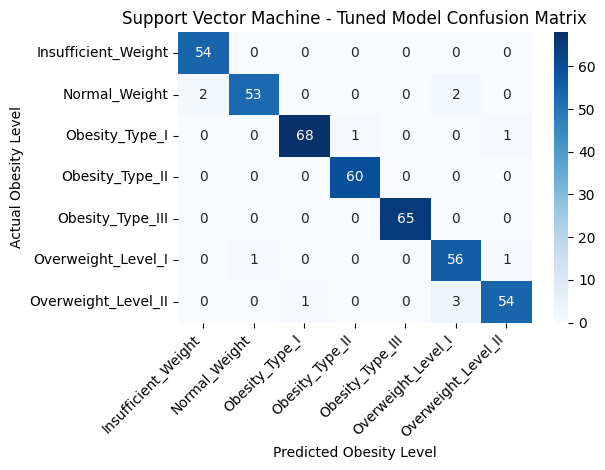


TUNED ERROR ANALYSIS:
Total samples: 422
Correct predictions: 410
Total misclassifications: 12
Overall accuracy: 0.9716

PER-CLASS ACCURACY ANALYSIS:
Insufficient_Weight:
  Total samples: 54
  Correct predictions: 54
  Misclassifications: 0
  Accuracy: 1.0000
Normal_Weight:
  Total samples: 57
  Correct predictions: 53
  Misclassifications: 4
  Accuracy: 0.9298
Obesity_Type_I:
  Total samples: 70
  Correct predictions: 68
  Misclassifications: 2
  Accuracy: 0.9714
Obesity_Type_II:
  Total samples: 60
  Correct predictions: 60
  Misclassifications: 0
  Accuracy: 1.0000
Obesity_Type_III:
  Total samples: 65
  Correct predictions: 65
  Misclassifications: 0
  Accuracy: 1.0000
Overweight_Level_I:
  Total samples: 58
  Correct predictions: 56
  Misclassifications: 2
  Accuracy: 0.9655
Overweight_Level_II:
  Total samples: 58
  Correct predictions: 54
  Misclassifications: 4
  Accuracy: 0.9310

ERROR PATTERN ANALYSIS:
Most common error: Overweight_Level_II → Overweight_Level_I (3 cases)
Sig

In [22]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING: SUPPORT VECTOR MACHINE")
print("="*60)

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

print("\nPARAMETER GRID:")
print(f"- C: {svm_param_grid['C']}")
print(f"- kernel: {svm_param_grid['kernel']}")
print(f"- gamma: {svm_param_grid['gamma']}")
print(f"- Total combinations: {len(svm_param_grid['C']) * len(svm_param_grid['kernel']) * len(svm_param_grid['gamma'])}")

# Perform hyperparameter tuning
svm_tuning_results = perform_hyperparameter_tuning(
    SVC(random_state=42),
    svm_param_grid,
    X_train_processed,
    y_train,
    X_test_processed,
    y_test,
    "Support Vector Machine",
    cv,
    svm_baseline_accuracy,
    target_encoder.classes_
)

# Extract tuned results
svm_tuned_model = svm_tuning_results['best_model']
svm_best_params = svm_tuning_results['best_params']
svm_tuned_accuracy = svm_tuning_results['best_single_accuracy']
svm_tuned_cv_score = svm_tuning_results['best_cv_score']

##### 7.3.3. Baseline vs Tuned Comparison for Support Vector Machine 

In [23]:
print("\n" + "="*60)
print("BASELINE vs TUNED COMPARISON FOR SUPPORT VECTOR MACHINE")
print("="*60)

print(f"Baseline Accuracy: {svm_baseline_accuracy:.4f}")
print(f"Tuned Accuracy: {svm_tuned_accuracy:.4f}")
print(f"Improvement: {svm_tuned_accuracy - svm_baseline_accuracy:.4f}")
print(f"Best Parameters: {svm_best_params}")

# Store results for final comparison
svm_accuracy = svm_tuned_accuracy  # Use tuned accuracy for final comparison
svm_model = svm_tuned_model
svm_pred = svm_tuning_results['predictions']


BASELINE vs TUNED COMPARISON FOR SUPPORT VECTOR MACHINE
Baseline Accuracy: 0.9265
Tuned Accuracy: 0.9716
Improvement: 0.0450
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


#### 7.4. Logistic Regression Classifier

##### 7.4.1. Baseline Logistic Regression Evaluation


LOGISTIC REGRESSION BASELINE MODEL EVALUATION:
Baseline Logistic Regression Accuracy: 0.8815

Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        54
           1       0.82      0.70      0.75        57
           2       0.94      0.89      0.91        70
           3       0.91      1.00      0.95        60
           4       1.00      1.00      1.00        65
           5       0.72      0.81      0.76        58
           6       0.87      0.79      0.83        58

    accuracy                           0.88       422
   macro avg       0.88      0.88      0.88       422
weighted avg       0.88      0.88      0.88       422


BASELINE CONFUSION MATRIX ANALYSIS:


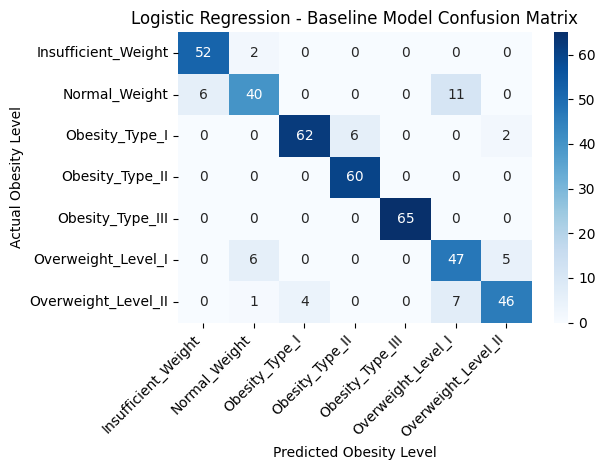


BASELINE ERROR ANALYSIS:
Total samples: 422
Correct predictions: 372
Total misclassifications: 50
Overall accuracy: 0.8815

PER-CLASS ACCURACY ANALYSIS:
Insufficient_Weight:
  Total samples: 54
  Correct predictions: 52
  Misclassifications: 2
  Accuracy: 0.9630
Normal_Weight:
  Total samples: 57
  Correct predictions: 40
  Misclassifications: 17
  Accuracy: 0.7018
Obesity_Type_I:
  Total samples: 70
  Correct predictions: 62
  Misclassifications: 8
  Accuracy: 0.8857
Obesity_Type_II:
  Total samples: 60
  Correct predictions: 60
  Misclassifications: 0
  Accuracy: 1.0000
Obesity_Type_III:
  Total samples: 65
  Correct predictions: 65
  Misclassifications: 0
  Accuracy: 1.0000
Overweight_Level_I:
  Total samples: 58
  Correct predictions: 47
  Misclassifications: 11
  Accuracy: 0.8103
Overweight_Level_II:
  Total samples: 58
  Correct predictions: 46
  Misclassifications: 12
  Accuracy: 0.7931

ERROR PATTERN ANALYSIS:
Most common error: Normal_Weight → Overweight_Level_I (11 cases)
Si

In [24]:
print("\nLOGISTIC REGRESSION BASELINE MODEL EVALUATION:")
print("="*50)

# Initialize and train baseline Logistic Regression
lr_baseline = LogisticRegression(solver='lbfgs', max_iter=5000, random_state=42)
lr_baseline.fit(X_train_processed, y_train)

# Evaluate baseline model
lr_baseline_pred = lr_baseline.predict(X_test_processed)
lr_baseline_accuracy = accuracy_score(y_test, lr_baseline_pred)

print(f"Baseline Logistic Regression Accuracy: {lr_baseline_accuracy:.4f}")
print("\nBaseline Classification Report:")
print(classification_report(y_test, lr_baseline_pred))

# Baseline Confusion Matrix Analysis using reusable function
lr_baseline_analysis = analyze_confusion_matrix(y_test, lr_baseline_pred, "Logistic Regression", "Baseline", target_encoder.classes_)


##### 7.4.2 Hyperparameter tuning for Logistic Regression


HYPERPARAMETER TUNING: LOGISTIC REGRESSION

PARAMETER GRID:
- C: [0.01, 0.1, 1, 10, 100]
- solver: ['lbfgs', 'saga']
- max_iter: [2000, 5000, 10000]
- Total combinations: 30

HYPERPARAMETER TUNING: Logistic Regression

TUNING METHODOLOGY:
- Technique: Grid Search with Cross-Validation
- Cross-validation: StratifiedKFold
- Parameter combinations: 10
- Total evaluations: 50

PERFORMING GRID SEARCH:
Fitting 5 folds for each of 30 candidates, totalling 150 fits

TUNING RESULTS:
Best cross-validation accuracy: 0.9555
Best parameters: {'C': 100, 'max_iter': 2000, 'solver': 'lbfgs'}
Number of parameter combinations tested: 30

PERFORMANCE COMPARISON:
Best model single split accuracy: 0.9645
Improvement over baseline: 0.0829

DETAILED CLASSIFICATION REPORT (Tuned Model):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        54
           1       0.98      0.93      0.95        57
           2       0.99      0.94      0.96        70
        

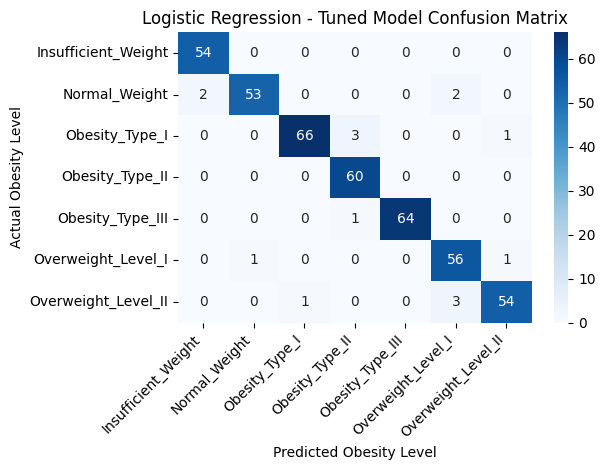


TUNED ERROR ANALYSIS:
Total samples: 422
Correct predictions: 407
Total misclassifications: 15
Overall accuracy: 0.9645

PER-CLASS ACCURACY ANALYSIS:
Insufficient_Weight:
  Total samples: 54
  Correct predictions: 54
  Misclassifications: 0
  Accuracy: 1.0000
Normal_Weight:
  Total samples: 57
  Correct predictions: 53
  Misclassifications: 4
  Accuracy: 0.9298
Obesity_Type_I:
  Total samples: 70
  Correct predictions: 66
  Misclassifications: 4
  Accuracy: 0.9429
Obesity_Type_II:
  Total samples: 60
  Correct predictions: 60
  Misclassifications: 0
  Accuracy: 1.0000
Obesity_Type_III:
  Total samples: 65
  Correct predictions: 64
  Misclassifications: 1
  Accuracy: 0.9846
Overweight_Level_I:
  Total samples: 58
  Correct predictions: 56
  Misclassifications: 2
  Accuracy: 0.9655
Overweight_Level_II:
  Total samples: 58
  Correct predictions: 54
  Misclassifications: 4
  Accuracy: 0.9310

ERROR PATTERN ANALYSIS:
Most common error: Obesity_Type_I → Obesity_Type_II (3 cases)
Significant

In [25]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING: LOGISTIC REGRESSION")
print("="*60)

# Define parameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [2000, 5000, 10000]
}

print("\nPARAMETER GRID:")
print(f"- C: {lr_param_grid['C']}")
print(f"- solver: {lr_param_grid['solver']}")
print(f"- max_iter: {lr_param_grid['max_iter']}")
print(f"- Total combinations: {len(lr_param_grid['C']) * len(lr_param_grid['solver']) * len(lr_param_grid['max_iter'])}")

# Perform hyperparameter tuning
lr_tuning_results = perform_hyperparameter_tuning(
    LogisticRegression(random_state=42),
    lr_param_grid,
    X_train_processed,
    y_train,
    X_test_processed,
    y_test,
    "Logistic Regression",
    cv,
    lr_baseline_accuracy,
    target_encoder.classes_
)

# Extract tuned results
lr_tuned_model = lr_tuning_results['best_model']
lr_best_params = lr_tuning_results['best_params']
lr_tuned_accuracy = lr_tuning_results['best_single_accuracy']
lr_tuned_cv_score = lr_tuning_results['best_cv_score']

##### 7.4.3 Baseline vs Tuning Comparison for Logistic Regression

In [26]:
print("\n" + "="*60)
print("BASELINE vs TUNED COMPARISON FOR LOGISTIC REGRESSION")
print("="*60)

print(f"Baseline Accuracy: {lr_baseline_accuracy:.4f}")
print(f"Tuned Accuracy: {lr_tuned_accuracy:.4f}")
print(f"Improvement: {lr_tuned_accuracy - lr_baseline_accuracy:.4f}")
print(f"Best Parameters: {lr_best_params}")

# Feature importance analysis for Logistic Regression
print("\nFEATURE IMPORTANCE ANALYSIS:")
# Get the actual number of features from the model
actual_features_lr = len(lr_tuned_model.coef_[0])
if len(feature_names) != actual_features:
    print(f"WARNING: Feature count mismatch! Creating descriptive feature names.")
    # Create descriptive feature names using available feature names
    feature_names_actual = []
    for i in range(actual_features):
        if i < len(feature_names):
            # Use the actual feature name if available
            feature_names_actual.append(f"Feature_{feature_names[i]}_{i}")
        else:
            # Fallback to generic name for extra features
            feature_names_actual.append(f"Feature_Extra_{i}")
else:
    feature_names_actual = feature_names

feature_importance_lr = pd.DataFrame({
    'Feature': feature_names_actual,
    'Coefficient': lr_tuned_model.coef_[0]  # For multi-class, we look at first class
}).sort_values('Coefficient', key=abs, ascending=False)

print("Top 10 most important features (by absolute coefficient value):")
print(feature_importance_lr.head(10))

# Store results for final comparison
lr_accuracy = lr_tuned_accuracy  # Use tuned accuracy for final comparison
lr_model = lr_tuned_model
lr_pred = lr_tuning_results['predictions']


BASELINE vs TUNED COMPARISON FOR LOGISTIC REGRESSION
Baseline Accuracy: 0.8815
Tuned Accuracy: 0.9645
Improvement: 0.0829
Best Parameters: {'C': 100, 'max_iter': 2000, 'solver': 'lbfgs'}

FEATURE IMPORTANCE ANALYSIS:
Top 10 most important features (by absolute coefficient value):
                      Feature  Coefficient
2            Feature_Weight_2   -71.763362
1            Feature_Height_1    19.142411
8              Feature_CAEC_8     2.875253
13   Feature_SMOKE_encoded_13    -2.133950
15  Feature_MTRANS_encoded_15    -2.000813
17           Feature_Extra_17    -1.711714
0               Feature_Age_0    -1.586212
16           Feature_Extra_16     0.827755
9              Feature_CALC_9    -0.800228
10  Feature_Gender_encoded_10    -0.666424


## 8. Model Comparisons

In [27]:
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)

# Create comprehensive comparison table using tuned model results
model_comparison = {
    'Model': ['Decision Tree', 'K-Nearest Neighbors', 'Support Vector Machine', 'Logistic Regression'],
    'CV_Mean_Accuracy': [dt_tuned_cv_score, knn_tuned_cv_score, svm_tuned_cv_score, lr_tuned_cv_score],
    'CV_Std_Accuracy': [dt_tuning_results['best_cv_std'], knn_tuning_results['best_cv_std'], 
                        svm_tuning_results['best_cv_std'], lr_tuning_results['best_cv_std']],
    'Single_Split_Accuracy': [dt_accuracy, knn_accuracy, svm_accuracy, lr_accuracy],
    'Difference': [dt_tuned_cv_score - dt_accuracy, knn_tuned_cv_score - knn_accuracy, 
                   svm_tuned_cv_score - svm_accuracy, lr_tuned_cv_score - lr_accuracy]
}

comparison_df = pd.DataFrame(model_comparison)
print("COMPREHENSIVE PERFORMANCE COMPARISON:")
print("="*70)
print(comparison_df.round(4))


MODEL COMPARISON
COMPREHENSIVE PERFORMANCE COMPARISON:
                    Model  CV_Mean_Accuracy  CV_Std_Accuracy  \
0           Decision Tree            0.9472           0.0115   
1     K-Nearest Neighbors            0.8791           0.0197   
2  Support Vector Machine            0.9573           0.0061   
3     Logistic Regression            0.9555           0.0075   

   Single_Split_Accuracy  Difference  
0                 0.9716     -0.0243  
1                 0.8910     -0.0119  
2                 0.9716     -0.0142  
3                 0.9645     -0.0089  


#### 8.1. Visual Comparison

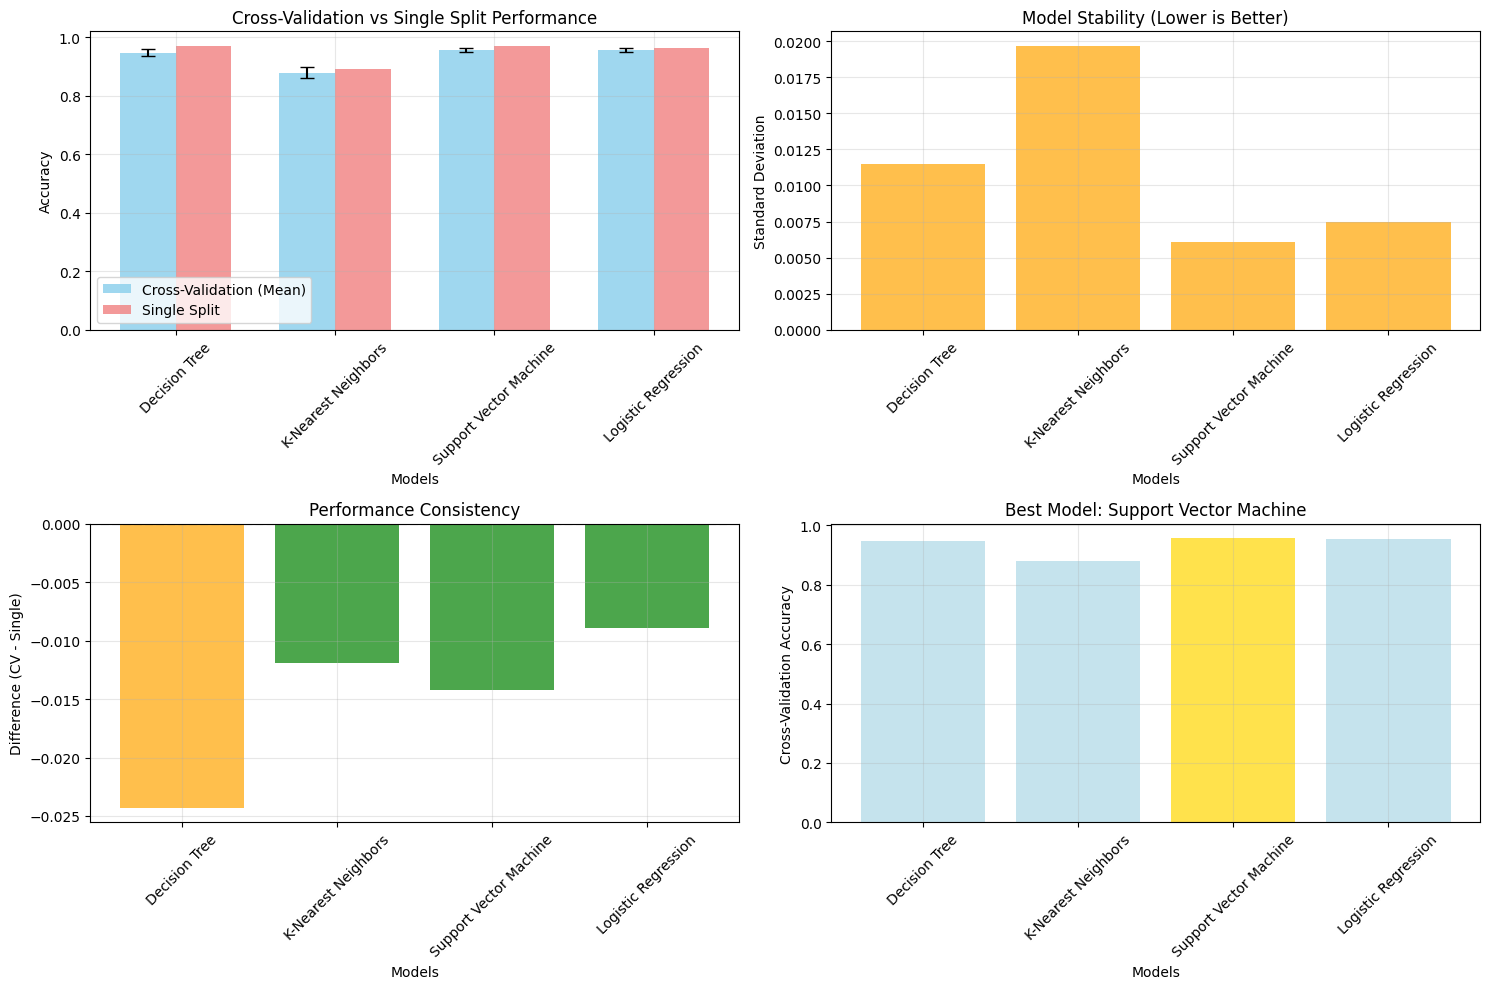

In [28]:
# Visual comparison with cross-validation
plt.figure(figsize=(15, 10))

# Subplot 1: Cross-validation vs Single Split
plt.subplot(2, 2, 1)
x = np.arange(len(model_comparison['Model']))
width = 0.35

plt.bar(x - width/2, comparison_df['CV_Mean_Accuracy'], width, 
        label='Cross-Validation (Mean)', alpha=0.8, color='skyblue')
plt.bar(x + width/2, comparison_df['Single_Split_Accuracy'], width, 
        label='Single Split', alpha=0.8, color='lightcoral')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Cross-Validation vs Single Split Performance')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add error bars for cross-validation
plt.errorbar(x - width/2, comparison_df['CV_Mean_Accuracy'], 
             yerr=comparison_df['CV_Std_Accuracy'], fmt='none', color='black', capsize=5)

# Subplot 2: Model Stability (Standard Deviation)
plt.subplot(2, 2, 2)
plt.bar(x, comparison_df['CV_Std_Accuracy'], color='orange', alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Standard Deviation')
plt.title('Model Stability (Lower is Better)')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.grid(True, alpha=0.3)

# Subplot 3: Performance Consistency
plt.subplot(2, 2, 3)
colors = ['green' if abs(diff) < 0.02 else 'orange' if abs(diff) < 0.05 else 'red' 
          for diff in comparison_df['Difference']]
plt.bar(x, comparison_df['Difference'], color=colors, alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Difference (CV - Single)')
plt.title('Performance Consistency')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

# Subplot 4: Best Model Selection
plt.subplot(2, 2, 4)
best_cv_accuracy = comparison_df['CV_Mean_Accuracy'].max()
best_model_idx = comparison_df['CV_Mean_Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']

plt.bar(x, comparison_df['CV_Mean_Accuracy'], color=['gold' if i == best_model_idx else 'lightblue' 
        for i in range(len(x))], alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Cross-Validation Accuracy')
plt.title(f'Best Model: {best_model_name}')
plt.xticks(x, comparison_df['Model'], rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 8.1. Statistical analysis and conclusions


In [29]:
print("\n" + "="*70)
print("STATISTICAL ANALYSIS AND CONCLUSIONS")
print("="*70)

print("\nMODEL STABILITY RANKING:")
stability_ranking = comparison_df.sort_values('CV_Std_Accuracy')
for i, (_, row) in enumerate(stability_ranking.iterrows(), 1):
    print(f"{i}. {row['Model']}: Std = {row['CV_Std_Accuracy']:.4f}")

print("\nPERFORMANCE CONSISTENCY:")
consistent_models = comparison_df[abs(comparison_df['Difference']) < 0.02]['Model'].tolist()
moderately_consistent = comparison_df[(abs(comparison_df['Difference']) >= 0.02) & 
                                    (abs(comparison_df['Difference']) < 0.05)]['Model'].tolist()
inconsistent_models = comparison_df[abs(comparison_df['Difference']) >= 0.05]['Model'].tolist()

print(f"Consistent models (diff < 2%): {', '.join(consistent_models) if consistent_models else 'None'}")
print(f"Moderately consistent (2-5%): {', '.join(moderately_consistent) if moderately_consistent else 'None'}")
print(f"Inconsistent models (diff ≥ 5%): {', '.join(inconsistent_models) if inconsistent_models else 'None'}")

print("\nBEST MODEL SELECTION:")
print(f"Best cross-validation accuracy: {best_model_name} ({best_cv_accuracy:.4f})")
print(f"Most stable model: {stability_ranking.iloc[0]['Model']} (Std = {stability_ranking.iloc[0]['CV_Std_Accuracy']:.4f})")



STATISTICAL ANALYSIS AND CONCLUSIONS

MODEL STABILITY RANKING:
1. Support Vector Machine: Std = 0.0061
2. Logistic Regression: Std = 0.0075
3. Decision Tree: Std = 0.0115
4. K-Nearest Neighbors: Std = 0.0197

PERFORMANCE CONSISTENCY:
Consistent models (diff < 2%): K-Nearest Neighbors, Support Vector Machine, Logistic Regression
Moderately consistent (2-5%): Decision Tree
Inconsistent models (diff ≥ 5%): None

BEST MODEL SELECTION:
Best cross-validation accuracy: Support Vector Machine (0.9573)
Most stable model: Support Vector Machine (Std = 0.0061)


## 9. CLINICAL VALIDATION SUMMARY

In [30]:
print("\n1. MODEL RELIABILITY FOR CLINICAL USE:")
print("="*50)

print("Cross-Validation Reliability:")
print(f"- Best model: {best_model_name} with {best_cv_accuracy:.4f} CV accuracy")
print(f"- Most stable: {stability_ranking.iloc[0]['Model']} (Std = {stability_ranking.iloc[0]['CV_Std_Accuracy']:.4f})")
print(f"- Performance consistency: {len(consistent_models)} models show consistent performance")

print("\nClinical Reliability Assessment:")
if best_cv_accuracy >= 0.85:
    print("✓ High reliability for clinical applications")
elif best_cv_accuracy >= 0.75:
    print("✓ Moderate reliability for clinical applications")
else:
    print("⚠ Limited reliability for clinical applications")


print("\nClinical Implementation Readiness:")
if best_cv_accuracy >= 0.80 and stability_ranking.iloc[0]['CV_Std_Accuracy'] < 0.05:
    print("✓ READY for clinical pilot implementation")
elif best_cv_accuracy >= 0.75:
    print("✓ SUITABLE for research and development")
else:
    print("⚠ REQUIRES further optimization before clinical use")



1. MODEL RELIABILITY FOR CLINICAL USE:
Cross-Validation Reliability:
- Best model: Support Vector Machine with 0.9573 CV accuracy
- Most stable: Support Vector Machine (Std = 0.0061)
- Performance consistency: 3 models show consistent performance

Clinical Reliability Assessment:
✓ High reliability for clinical applications

Clinical Implementation Readiness:
✓ READY for clinical pilot implementation
